# MP2: Linear Regression

## `Part 1` : Multivariate Linear Regression from Scratch

In this notebook we will be implementing multivariate linear regression (from scratch) to predict the the median price of homes in a Boston suburb during the mid-1970s. Multivariate linear regression is to be used here to model the relationship between multiple independent variables and a single dependent variable. 

To do this, we are given with a dataset that has 404 examples in the train set and 102 examples in test set. Each example has 13 input variables (features) and one output variable (price in $10,000s). Below is the description of given input variables:

- Per-capita crime rate.
- The proportion of residential land zoned for lots over 25,000 square feet.
- The proportion of non-retail business acres per town.
- Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
- Nitric oxides concentration (parts per 10 million).
- The average number of rooms per dwelling.
- The proportion of owner-occupied units built before 1940.
- Weighted distances to five Boston employment centers.
- Index of accessibility to radial highways.
- Full-value property tax rate per $10,000.
- Pupil-teacher ratio by town.
- 1000 * ('B' - 0.63) ** 2 where 'B' is the proportion of Black people by town.
- Percentage lower status of the population.

Each one of these input features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on.

A common way to normalize features that use different scales and ranges is:

- Subtract the mean value of each feature from the dataset.

- After subtracting the mean, additionally scale (divide) the feature values by their respective standard deviations.

Note: We only use examples of the train set to estimate the mean and standard deviation.

### Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Preparing Data

Loading in the data into train and test sets and applying preprocessing steps to cater for missing values and categorical variables wherever needed. 

In [6]:
def load_data(file_path):
    data = np.loadtxt(file_path)
    return data

train_data = load_data("trainData.txt")
train_labels = load_data("trainLabels.txt")
test_data = load_data("testData.txt")
test_labels = load_data("testLabels.txt")

# printing the shapes of the imported data
print("shape of train data:", train_data.shape)
print("shape of train labels:", train_labels.shape)
print("shape of test data:", test_data.shape)
print("shape of test labels:", test_labels.shape)

shape of train data: (404, 13)
shape of train labels: (404,)
shape of test data: (102, 13)
shape of test labels: (102,)


### Normalizing Data

One nice way to implement this is to create a class, `StandardScaler` that can be used to store the mean and standard deviation of each feature of the training set. The `StandardScaler` class also has two functions, `fit` and `transform`.

- The `fit` function is used to calculate the mean and standard deviation of each feature of the training set.

- The `transform` function is used to transform all the features using the corresponding mean and standard deviation, i.e. subtracting the mean and dividing by the standard deviation.

A very subtle and important point to note here is that the mean and standard deviation should be calculated only on the training set, and then applied to the test set. This is because in real-world scenarios, we do not have access to the test set, and hence we cannot calculate the mean and standard deviation of the test set.

In [8]:
class StandardScaler:
    def __init__(self):
        
        # the constructor
        self.mean = None
        self.std = None

    def fit(self, data):

        # axis is set to zero to ensure that the mean and std is calculated along columns rather than along rows
        self.mean = np.mean(data, axis = 0) 
        self.std = np.std(data, axis = 0)

    def transform(self, data):
        
        # transforming the data
        transformed_value = (data - self.mean) / self.std
        return transformed_value

### Visualising the Normalized Data

Using histograms for this purpose:

Std of Training Data [NORMALISED]: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Shape of Training Data [NORMALISED]: (404, 13)


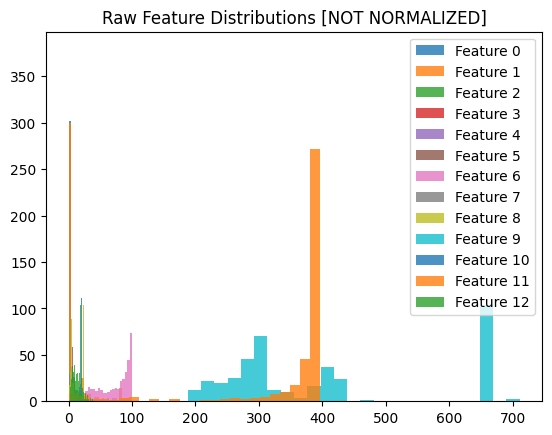

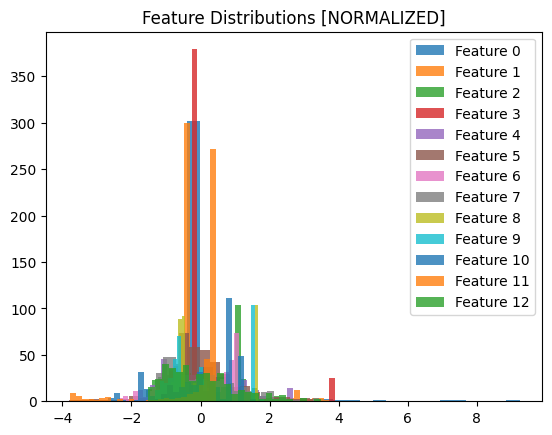

In [13]:
# visualising the normalisation of the dataset using histograms
s1 = StandardScaler()
s1.fit(train_data)

# normalising the train and the test data
normalized_train_data = s1.transform(train_data)
normalized_test_data = s1.transform(test_data)

# printing the std of the normalised training data to ensure that the data is indeed normalised (if std equals 1, data has been normalised)
print("Std of Training Data [NORMALISED]:", np.std(normalized_train_data, axis = 0))
print("Shape of Training Data [NORMALISED]:", normalized_train_data.shape)

# adding a histogram for better vidualisation of the normalization of the data
for feature_index in range(train_data.shape[1]):
    plt.hist(train_data[:, feature_index], bins = 25, alpha = 0.8, label = f"Feature {feature_index}")
    
plt.legend()
plt.title("Raw Feature Distributions [NOT NORMALIZED]")
plt.show()

for feature_index in range(normalized_train_data.shape[1]):
    plt.hist(normalized_train_data[:, feature_index], bins = 25, alpha = 0.8, label = f"Feature {feature_index}")
    
plt.legend()
plt.title("Feature Distributions [NORMALIZED]")
plt.show()

### Applying Gradient Descent

Now that the data is normalized, we can start implementing the gradient descent algorithm. The class `LR_scratch` implements the gradient descent algorithm. The descriptions of the methods in the class are given below:

- `__init__`: The constructor of the class. Here we initialize variables, like the learning rate and the number of iterations.

- `fit`: This method will be used to train the model. It will take in the training data and labels as parameters, and learn the parameters using gradient descent. Also, save the loss values after every iteration in a list, and return it.

- `predict`: This method will be used to predict the labels for a given set of test data. It takes in the test data as a parameter, and return the predicted labels.

- `score`: This method will be used to calculate the mean square error for the test data. It takes in the test data and labels as parameters, and returns the mean square error.

Lastly, the cost function is to be plotted, and the mean square error for both the train and test set printed.

In [16]:
class LR_scratch:
    def __init__(self, learning_rate = 0.001, num_iterations = 10000):
        """
        The constructor for the LinearRegression class. 

        The learning rate controls the step size of the gadient descent 
        and have been set to a default value of 0.001.

        The number of iterations are set to a default value of 10000
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.theta = None
        self.bias = None

    def fit(self, X, y):

        # initializing the parameters
        n_samples = X.shape[0] # number of data samples
        self.theta = np.zeros(X.shape[1])
        self.bias = 0
        loss_history = []  # the list that will store the loss values

        # the gradient descent algorithm
        for _ in range(self.num_iterations):

            y_predicted = np.dot(X, self.theta) + self.bias

            # computing the gradients
            d_theta = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            d_loss = (1 / n_samples) * np.sum(y_predicted - y) 

            # updating the parameters
            self.theta -= self.learning_rate * d_theta
            self.bias -= self.learning_rate * d_loss

            loss_history.append(np.mean(np.power((y_predicted - y), 2)))
                                
        return loss_history

    def predict(self, X):
        # y` mx + b where m is theta and b is bias
        prediction = np.dot(X, self.theta) + self.bias
        return prediction
    
    def score(self, X, y):
        y_pred = self.predict(X)
        mean_squared_error = np.mean(np.power((y_pred - y), 2))
        return mean_squared_error/2

### Running the Model:

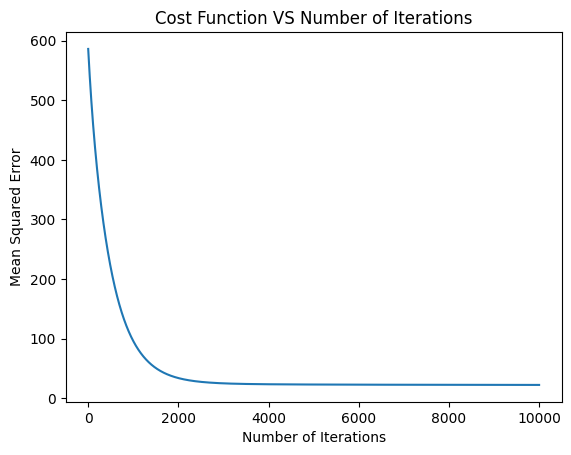

Mean Square Error (MSE) for the Train Set: 11.15504689742283
Mean Square Error (MSE) for the Test Set: 11.273595193452385


In [23]:
LR1 = LR_scratch(0.001, 10000)
loss_history = LR1.fit(normalized_train_data, train_labels)

# Plotting the cost function (loss) over default 10,000 iterations
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Number of Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Cost Function VS Number of Iterations")
plt.show()

# Calculating and printing the mean square error for both the train and test sets
train_mse = LR1.score(normalized_train_data, train_labels)
test_mse = LR1.score(normalized_test_data, test_labels)

print("Mean Square Error (MSE) for the Train Set:", train_mse)
print("Mean Square Error (MSE) for the Test Set:", test_mse)

## `Part 2` : Regularized Linear Regression Using Scikit-learn

As an additional excercise we'll be using [Scikit-Learn](https://scikit-learn.org/stable/index.html) to implement [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge), [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) and apply them to Boston house pricing dataset. 

Also, we will also be implementing regularization techniques namely, `Ridge` , `Lasso` and `Elastic Net` on the same model from scikit-learn. 


### Importing Libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

### Linear Regression using `scikit-learn`

Using the [Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) loss function.

In [46]:
# normalising the train and the test data using scikit-learn's built-in function for normalisation
normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)

LR2 = LinearRegression()

# fitting the LR model to the training data
LR2.fit(normalized_train_data, train_labels)

# predicting the test data using the trained model
predicted_labels = LR2.predict(normalized_test_data)

# calculating the mean squared error between the predicted labels and 'test_labels'
mean_squared_error2 = mean_squared_error(test_labels, predicted_labels)
mean_squared_error2 = mean_squared_error2 / 2

print("Mean Squared Error (MSE) with Linear Regression from scikit-learn:", mean_squared_error2)

Mean Squared Error (MSE) with Linear Regression from scikit-learn: 9.08275524674824


#### Ridge Regularization

The formula for ridge regularization is as follows:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Cost&nbsp;Function</mtext><mo>=</mo><mtext>Loss</mtext><mo>+</mo><mfrac><mn>1</mn><mn>2</mn></mfrac><mi>λ</mi><munderover><mo>∑</mo><mrow><mi>j</mi><mo>=</mo><mn>1</mn></mrow><mi>m</mi></munderover><msubsup><mi>w</mi><mi>j</mi><mn>2</mn></msubsup></mrow><annotation encoding="application/x-tex">\text{Cost Function} = \text{Loss} + \frac{1}{2} \lambda \sum_{j=1}^m w_j^2 
</annotation></semantics></math>

Here, `Loss` represents the sum of squared residuals (similar to regular linear regression). `λ` (lambda) controls the strength of regularization and `w_j` denotes the weight (coefficient) associated with the `j-th` feature.

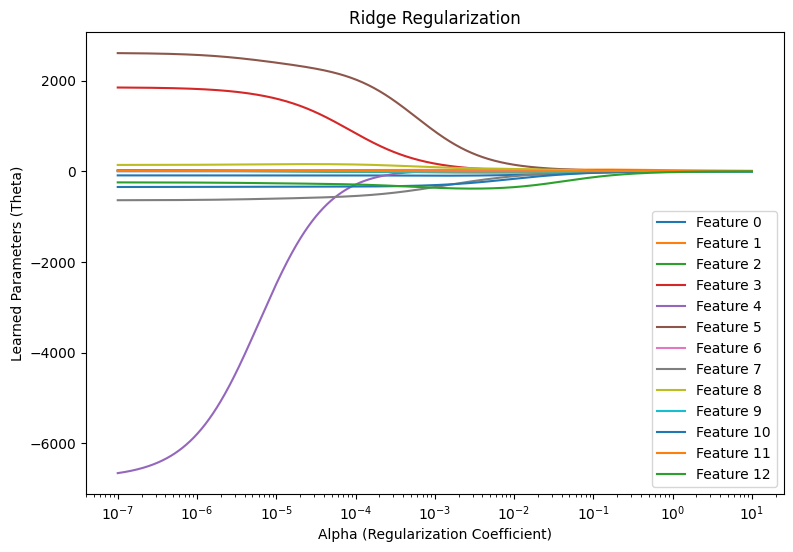

Mean Squared Error (MSE) using Ridge Regression with best alpha: 17.77597356979843
Best Alpha: 2.9817722900196734e-05


In [48]:
alphas = np.logspace(-7, 1, 1000)
mse_values = []
theta_values = []

for alpha in alphas:
    
    ridge = Ridge(alpha = alpha)
    
    # fitting the model to the training data
    ridge.fit(normalized_train_data, train_labels)

    # predicting on the test data
    test_predictions = ridge.predict(normalized_test_data)

    # calculating the Mean Squared Error (MSE)
    mean_squared_error3 = mean_squared_error(test_labels, test_predictions)
    mse_values.append(mean_squared_error3)
    theta_values.append(ridge.coef_)

plt.figure(figsize = (9, 6))
for i in range(normalized_train_data.shape[1]):
    feature_values = [theta[i] for theta in theta_values]
    plt.plot(alphas, feature_values, label = f"Feature {i}")

plt.xscale("log")
plt.xlabel("Alpha (Regularization Coefficient)")
plt.ylabel("Learned Parameters (Theta)")
plt.title("Ridge Regularization")
plt.legend()
plt.show()

best_alpha = alphas[np.argmin(mse_values)]

print("Mean Squared Error (MSE) using Ridge Regression with best alpha:", min(mse_values))
print("Best Alpha:", best_alpha)

#### Lasso Regularization

The respective formula is as follows:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Cost&nbsp;Function</mtext><mo>=</mo><mtext>Loss</mtext><mo>+</mo><mi>λ</mi><munderover><mo>∑</mo><mrow><mi>j</mi><mo>=</mo><mn>1</mn></mrow><mi>m</mi></munderover><mi mathvariant="normal">∣</mi><msub><mi>w</mi><mi>j</mi></msub><mi mathvariant="normal">∣</mi></mrow><annotation encoding="application/x-tex">\text{Cost Function} = \text{Loss} + \lambda \sum_{j=1}^m |w_j| 
</annotation></semantics></math>


Here, `Loss` represents the sum of squared residuals (similar to regular linear regression). `λ` (lambda) controls the strength of regularization. `w_j`​ denotes the weight (coefficient) associated with the `j-th` feature.

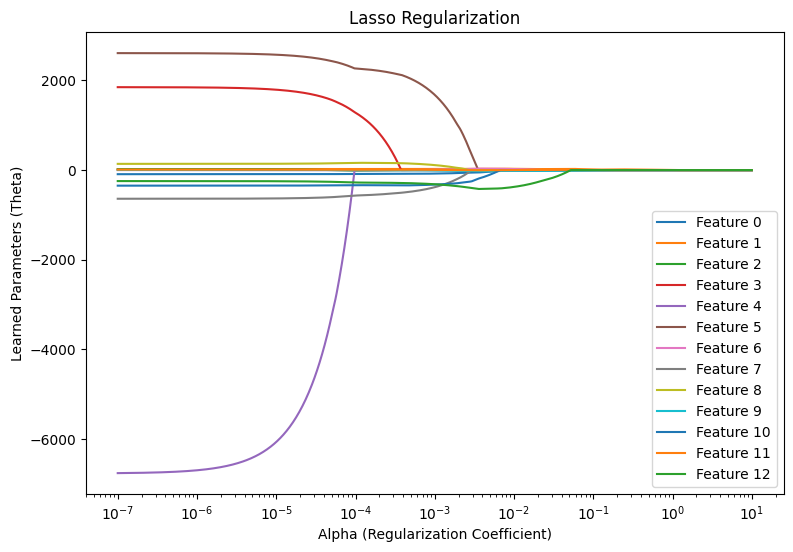

Mean Squared Error (MSE) using Lasso Regression with best alpha: 17.340213741512237
Best Alpha: 0.00029886528735503825


In [49]:
alphas = np.logspace(-7, 1, 1000)

mse_values = []
theta_values = []

for alpha in alphas:

    lasso = Lasso(alpha = alpha)

    # fitting the model to the training data
    lasso.fit(normalized_train_data, train_labels)

    # predict on the test data
    test_predictions = lasso.predict(normalized_test_data)

    # calculating the Mean Squared Error (MSE)
    mean_squared_error4 = mean_squared_error(test_labels, test_predictions)
    mse_values.append(mean_squared_error4)
    theta_values.append(lasso.coef_)

plt.figure(figsize = (9, 6))
for i in range(normalized_train_data.shape[1]):
    feature_values = [theta[i] for theta in theta_values]
    plt.plot(alphas, feature_values, label = f"Feature {i}")

plt.xscale("log")
plt.xlabel("Alpha (Regularization Coefficient)")
plt.ylabel("Learned Parameters (Theta)")
plt.title("Lasso Regularization")
plt.legend()
plt.show()

best_alpha = alphas[np.argmin(mse_values)]

print("Mean Squared Error (MSE) using Lasso Regression with best alpha:", min(mse_values))
print("Best Alpha:", best_alpha)

#### Elastic Net

Elastic Net is essentially the mix of both `ridge` and `lasso` regularization techniques. Its formula for the loss function implementation is shown below:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Elastic&nbsp;Net&nbsp;Cost&nbsp;Function</mtext><mo>=</mo><mtext>Loss&nbsp;Function</mtext><mo>+</mo><mi>r</mi><mi>λ</mi><munderover><mo>∑</mo><mrow><mi>j</mi><mo>=</mo><mn>1</mn></mrow><mi>m</mi></munderover><mi mathvariant="normal">∣</mi><msub><mi>w</mi><mi>j</mi></msub><mi mathvariant="normal">∣</mi><mo>+</mo><mfrac><mrow><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><mi>r</mi><mo stretchy="false">)</mo></mrow><mn>2</mn></mfrac><mi>λ</mi><munderover><mo>∑</mo><mrow><mi>j</mi><mo>=</mo><mn>1</mn></mrow><mi>m</mi></munderover><msubsup><mi>w</mi><mi>j</mi><mn>2</mn></msubsup></mrow><annotation encoding="application/x-tex">\text{Elastic Net Cost Function} = \text{Loss Function} + r \lambda \sum_{j=1}^m |w_j| + \frac{(1-r)}{2} \lambda \sum_{j=1}^m w_j^2 
</annotation></semantics></math>

This Loss Function measures prediction error (e.g., squared residuals).

`λ` controls the strength of regularization.

`r` balances the `L1` and `L2` penalties:

When `r = 1` , only `L1` penalty ( `lasso` ) remains.

When `r = 0` , only `L2` penalty ( `ridge` ) remains.

In [56]:
elastic_net = ElasticNet()

# fitting the model to the training data
elastic_net.fit(normalized_train_data, train_labels)

# predicting on the test data
test_predictions = elastic_net.predict(normalized_test_data)

# calculating the Mean Squared Error (MSE) 
mean_squared_error5 = mean_squared_error(test_labels, test_predictions)

print("Mean Squared Error (MSE) using Elastic Net Regression:", mean_squared_error5)

Mean Squared Error (MSE) using Elastic Net Regression: 81.86857976349874
